Date: 2024-11-01 00:00:00, Portfolio: 10, Available: 4.67, Pending Bets: 1
Date: 2024-11-02 00:00:00, Portfolio: 10, Available: 2.1808899999999998, Pending Bets: 2
Date: 2024-11-03 00:00:00, Portfolio: 20.66, Available: 8.48580563, Pending Bets: 2
Date: 2024-11-04 00:00:00, Portfolio: 25.63822, Available: 7.45011433921, Pending Bets: 2
Date: 2024-11-05 00:00:00, Portfolio: 45.00838874, Available: 17.04800659878107, Pending Bets: 2
Date: 2024-11-06 00:00:00, Portfolio: 36.50536744921, Available: 7.961419081630758, Pending Bets: 2
Date: 2024-11-07 00:00:00, Portfolio: 75.42008915006787, Available: 30.977745262572498, Pending Bets: 2
Date: 2024-11-08 00:00:00, Portfolio: 93.59326418436848, Available: 27.196916149148933, Pending Bets: 2
Date: 2024-11-09 00:00:00, Portfolio: 164.3047769250586, Available: 62.23437451650598, Pending Bets: 2
Date: 2024-11-10 00:00:00, Portfolio: 226.38596025480757, Available: 72.55132182169744, Pending Bets: 2
Date: 2024-11-11 00:00:00, Portfolio: 368.44558174

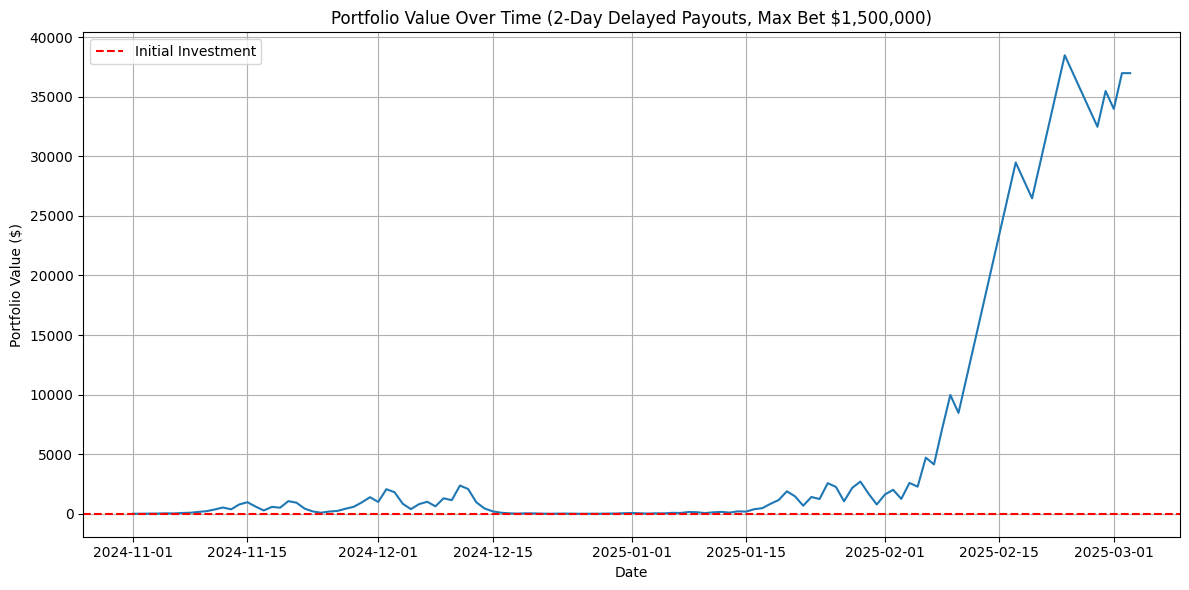

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data
forecast_data = pd.read_csv('trunc_forecast_max_temp.csv')
kalshi_data = pd.read_csv('filtered_kalshi_weather_data.csv')

# Parse dates
forecast_data['date'] = pd.to_datetime(forecast_data['date'])
kalshi_data['event_date'] = pd.to_datetime(kalshi_data['event_sub_title'].str.extract(r'On (.+)')[0], format='%b %d, %Y')

# Function to check if temperature falls within a range
def temp_in_range(temp, range_str):
    if '° or below' in range_str:
        upper = int(range_str.split('° or below')[0])
        return temp <= upper
    elif '° or above' in range_str:
        lower = int(range_str.split('° or above')[0])
        return temp >= lower
    elif 'to' in range_str:
        lower = int(range_str.split('° to ')[0])
        upper = int(range_str.split('to ')[1].split('°')[0])
        return lower <= temp <= upper
    return False

# Starting from November 1st, 2024
start_date = pd.Timestamp('2024-11-01')
forecast_data = forecast_data[forecast_data['date'] >= start_date].reset_index(drop=True)

# Prepare tracking variables
initial_capital = 10  # Starting with $10,000
available_capital = initial_capital
portfolio_value = initial_capital
portfolio_history = [portfolio_value]
dates = [start_date]
bet_history = []
pending_bets = []  # Track bets waiting for payout
wins = 0
losses = 0

# Maximum bet size
MAX_BET = 1500  # $1,500 max bet

# Dictionary to store correct temperature range for each day
correct_ranges = {}
for _, row in kalshi_data.iterrows():
    date = row['event_date']
    correct_ranges[date] = row['market_subtitle']

# Sort forecast data by date to ensure chronological processing
forecast_data = forecast_data.sort_values('date')

# Run the backtest
for _, row in forecast_data.iterrows():
    date = row['date']
    temp = row['forecasted_max_temp']

    # First, process any pending bets that are now due for payout (after 2 days)
    updated_pending_bets = []
    for pending_bet in pending_bets:
        bet_date = pending_bet['date']
        # Check if the bet is due for payout (2 days have passed)
        if (date - bet_date).days >= 2:
            # Apply the profit/loss to the portfolio
            portfolio_value += pending_bet['profit']

            # Record the payout in history
            bet_history.append({
                'date': date,
                'bet_date': bet_date,
                'forecast_temp': pending_bet['forecast_temp'],
                'correct_range': pending_bet['correct_range'],
                'forecast_correct': pending_bet['forecast_correct'],
                'bet_amount': pending_bet['bet_amount'],
                'profit': pending_bet['profit'],
                'result': pending_bet['result'],
                'portfolio_value': portfolio_value,
                'payout_delay': (date - bet_date).days
            })
        else:
            # Keep this bet in pending
            updated_pending_bets.append(pending_bet)

    # Update the pending bets list
    pending_bets = updated_pending_bets

    # Record portfolio value for this date (after processing any payouts)
    portfolio_history.append(portfolio_value)
    dates.append(date)

    # Check if we have Kalshi data for this date to make a new bet
    if date not in correct_ranges:
        # Update available capital for the next day
        available_capital = portfolio_value
        continue

    # Calculate available capital (after pending bets are accounted for)
    # Calculate the total amount tied up in pending bets
    pending_amount = sum(bet['bet_amount'] for bet in pending_bets)
    # Available capital is portfolio value minus pending bets
    available_capital = portfolio_value - pending_amount

    # Ensure we have enough capital to place a bet
    if available_capital <= 1:
        continue

    # Get the correct temperature range for this day
    correct_range = correct_ranges[date]

    # Check if our forecasted temperature falls within the correct range
    forecast_correct = temp_in_range(temp, correct_range)

    # Calculate bet amount (53.3% of available capital) with maximum cap
    calculated_bet = available_capital * 0.533
    bet_amount = min(calculated_bet, MAX_BET)  # Cap the bet at $1,500

    # Calculate theoretical outcome (but don't apply to portfolio yet)
    if forecast_correct:
        # Win: Triple the bet amount
        profit = bet_amount * 2  # (We get our bet back plus double)
        day_result = "win"
        wins += 1
    else:
        # Lose: Lose the entire bet
        profit = -bet_amount
        day_result = "lose"
        losses += 1

    # Add this bet to pending bets with its future payout
    pending_bets.append({
        'date': date,
        'forecast_temp': temp,
        'correct_range': correct_range,
        'forecast_correct': forecast_correct,
        'bet_amount': bet_amount,
        'profit': profit,
        'result': day_result
    })

    # Reduce available capital by the bet amount (money is tied up)
    available_capital -= bet_amount

    # Check for bankruptcy
    print(f"Date: {date}, Portfolio: {portfolio_value}, Available: {available_capital}, Pending Bets: {len(pending_bets)}")
    if portfolio_value <= 1:
        print(f"Bankrupt on {date}")
        break

# Process any remaining pending bets at the end of the backtest
if pending_bets:
    print(f"End of backtest with {len(pending_bets)} pending bets that never settled")
    # We could choose to simulate them settling, but instead we'll just note them

# Create results dataframe
results_df = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_history
})

# Calculate performance metrics
initial_value = portfolio_history[0]
final_value = portfolio_history[-1]
total_return = (final_value - initial_value) / initial_value * 100
num_trades = len(bet_history)
win_rate = (wins / (wins + losses) * 100) if (wins + losses) > 0 else 0

# Print results
print(f"Backtesting Results (with max bet of ${MAX_BET*1000:,.2f}):")
print(f"Starting Portfolio: ${initial_value:,.2f}")
print(f"Final Portfolio: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Settled Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2f}% ({wins} wins, {losses} losses)")
print(f"Pending Bets at End: {len(pending_bets)}")

if portfolio_value <= 0:
    print("Strategy went bankrupt during the testing period")

# Calculate max drawdown
portfolio_array = np.array(portfolio_history)
peak = np.maximum.accumulate(portfolio_array)
drawdown = (portfolio_array - peak) / peak * 100
max_drawdown = np.min(drawdown)
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Create a detailed bet history DataFrame
bet_df = pd.DataFrame(bet_history)

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_history)
plt.title(f'Portfolio Value Over Time (2-Day Delayed Payouts, Max Bet ${MAX_BET*1000:,.0f})')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.axhline(y=initial_value, color='r', linestyle='--', label='Initial Investment')
plt.legend()
plt.tight_layout()

# Analyze bet sizes and capital utilization
if not bet_df.empty:
    bet_df['bet_to_portfolio'] = bet_df['bet_amount'] / bet_df['portfolio_value'] * 100
    avg_bet_size = bet_df['bet_amount'].mean()
    avg_bet_pct = bet_df['bet_to_portfolio'].mean()
    max_bet_used = bet_df['bet_amount'].max()

    print(f"\nBet Size Analysis:")
    print(f"Average Bet Size: ${avg_bet_size:.2f}")
    print(f"Average Bet as % of Portfolio: {avg_bet_pct:.2f}%")
    print(f"Maximum Bet Used: ${max_bet_used:.2f}")
    print(f"Number of Times Max Bet Limit Applied: {sum(bet_df['bet_amount'] >= MAX_BET-0.01)}")

# Find winning and losing days
if not bet_df.empty:
    # Periods of consecutive wins and losses
    bet_df['streak'] = (bet_df['result'] != bet_df['result'].shift(1)).cumsum()
    streaks = bet_df.groupby(['streak', 'result']).size().reset_index(name='count')
    max_win_streak = streaks[streaks['result'] == 'win']['count'].max() if not streaks[streaks['result'] == 'win'].empty else 0
    max_loss_streak = streaks[streaks['result'] == 'lose']['count'].max() if not streaks[streaks['result'] == 'lose'].empty else 0

    print(f"\nLongest Win Streak: {max_win_streak} days")
    print(f"Longest Loss Streak: {max_loss_streak} days")

    # Monthly performance
    bet_df['month'] = bet_df['date'].dt.to_period('M')
    monthly = bet_df.groupby('month').agg({
        'result': lambda x: sum(x == 'win'),
        'profit': 'sum',
        'portfolio_value': 'last'
    }).reset_index()

    print("\nMonthly Performance:")
    for _, row in monthly.iterrows():
        month_name = row['month'].strftime('%b %Y')
        wins_in_month = row['result']
        trades_in_month = len(bet_df[bet_df['month'] == row['month']])
        win_rate_month = (wins_in_month / trades_in_month * 100) if trades_in_month > 0 else 0
        month_profit = row['profit']

        print(f"{month_name}: Win Rate {win_rate_month:.1f}%, Portfolio: ${row['portfolio_value']:,.2f}, Profit: ${month_profit:,.2f}")

# Show first few losing trades
losing_trades = bet_df[bet_df['result'] == 'lose']
if not losing_trades.empty:
    print("\nLosing Trades:")
    for i, (_, trade) in enumerate(losing_trades.iterrows()):
        print(f"{i+1}. Bet Date: {trade['bet_date'].strftime('%Y-%m-%d')}, Payout Date: {trade['date'].strftime('%Y-%m-%d')}")
        print(f"   Predicted {trade['forecast_temp']}°F, Correct Range was {trade['correct_range']}, Lost ${trade['bet_amount']:,.2f}")
        if i >= 4:  # Show at most 5 losing trades
            break

# Summary
print("\nStrategy Summary:")
if portfolio_value <= 0:
    print(f"Strategy went bankrupt after {len(bet_history)} trades on {dates[-1].strftime('%Y-%m-%d')}")
else:
    print(f"Starting with ${initial_value:,.2f} on {dates[0].strftime('%Y-%m-%d')}")
    print(f"Ending with ${final_value:,.2f} on {dates[-1].strftime('%Y-%m-%d')}")
    print(f"Total Return: {total_return:.2f}%")
    days_elapsed = (dates[-1] - dates[0]).days
    if days_elapsed > 0:
        annualized_return = ((final_value/initial_value) ** (365/days_elapsed) - 1) * 100
        print(f"Annualized Return: {annualized_return:.2f}%")